In [ ]:
from dask.distributed import Client

client = Client("tcp://10.32.3.9:35517")
client

# ECCO HEAT BUDGET - revised

### 13-tile native lat-lon-cap 90 grid
The lat-lon-cap (llc) is the decomposition of the spherical Earth into a Cartesian curvilinear coordinate system . It is a topologically non-trivial cubed-sphere rendering in the northern hemisphere and a dipolar grid in the southern hemisphere. Between 70°S and ~57°N, model grid cells are approximately oriented to lines of latitude and longitude. A special Arctic “cap” is situated north of ~57°N.

The Cartesian curvilinear coordinate system is divided into 13 tiles, each consisting of 90x90 grid cells in the horizontal and 50 vertical levels. Horizontal model grid resolution varies spatially from 22km to 110km, with the highest resolutions at high latitudes and lowest resolution in mid latitudes. Vertical grid spacing increases with depth from 10m to 456.5m. The bottom of the deepest model grid cell is 6145m below the surface.
https://ecco-v4-python-tutorial.readthedocs.io/fields.html

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [3]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

In [4]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 4

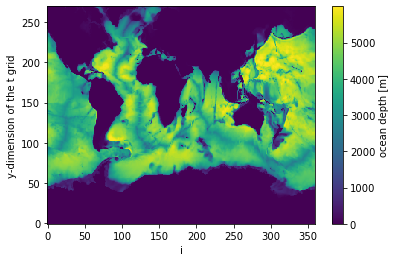

In [5]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=100).drop('i').plot()

In [6]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'k', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [7]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<shap

In [8]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
# Rename time (and iter) axis
dt = dt.rename({'time_snp':'time'})
# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}
ds.dt

<xarray.DataArray 'dt' (time: 288)>
array([     nan, 2505600., 2678400., ..., 2678400., 2592000.,      nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
Attributes:
    units:          s
    standard_name:  dt
    coordinate:     time
    long_name:      time span between snapshots

In [ ]:
coords.Z.plot()
#bins stretch vertically as you go down

In [ ]:
coords.Z.isel(k=36).values
#Z interior @ ~2km --> k=36

In [ ]:
coords.Zl.plot()

In [ ]:
coords.Z.isel(k=slice(36,50)).values

In [ ]:
coords.Zl.isel(k_l=slice(36,50)).values

In [ ]:
coords.Zl.isel(k_l=37).values

## Heat budget for WG (entire water column)

In [ ]:
sst_mean = ds.THETA.isel(k=0).mean(dim='time').load()

In [ ]:
surface_mask = (coords.hFacC[0]>0).load()
surface_mask

In [ ]:
sst_mean.where(surface_mask).plot(figsize=(12,6))
plt.grid();

In [ ]:
sst_mean_wg = sst_mean.sel(i=slice(55, 180), j=slice(30, 90))
surface_mask_wg = surface_mask.sel(i=slice(55, 180), j=slice(30, 90))

In [ ]:
sst_mean_wg = sst_mean.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg = surface_mask.sel(i=slice(75, 167), j=slice(35, 75))

In [ ]:
sst_mean_wg.where(surface_mask_wg).plot(figsize=(12,6))
plt.grid();

In [ ]:
left_i = 21
right_i = 120
upper_j = 44
lower_j = 9

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sst_mean_wg.where(surface_mask_wg).plot(ax=ax,  vmin=-2, vmax=10)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [ ]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [ ]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [ ]:
#advective flux
adv_flux_y = ds.ADVy_TH.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_TH.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [ ]:
#diffusive flux
diff_flux_y = ds.DFyE_TH.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_TH.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

In [ ]:
#vertical flux
t_flux_z = (ds.TFLUX.isel(**lat_range, **lon_range) * coords.rA.isel(**lat_range, **lon_range)).sum(dim=['i','j'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

In [ ]:
dsr.WVELMASS

In [ ]:
dsr.ETAN

In [ ]:
dsr.oceQsw

In [ ]:
dsr.oceFWflx

In [ ]:
dsr

In [ ]:
coords

In [ ]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.oceQsw.isel(k=0, drop=True) * coords.rA
                     ).isel(**lat_range, **lon_range).sum(dim=['XC', 'YC'])
#i noticed lin_fs_corr term didn't have `**lon_range` - should it not have?
#units: (˚C m^3)/s

In [ ]:
surface_term.load()

In [ ]:
lin_fs_correction.load()

In [ ]:
surface_term.plot(label='surf')
lin_fs_correction.plot(label='lin')
plt.legend()

## Heat budget for Lower WG (-2,046m to bottom)

In [9]:
coords.Z.isel(k=36).values

array(-1914.15, dtype=float32)

In [10]:
sst_mean_lower = ds.THETA.isel(k=36).mean(dim='time').load()

In [11]:
surface_mask_lower = (coords.hFacC.isel(k=36)>0).load()

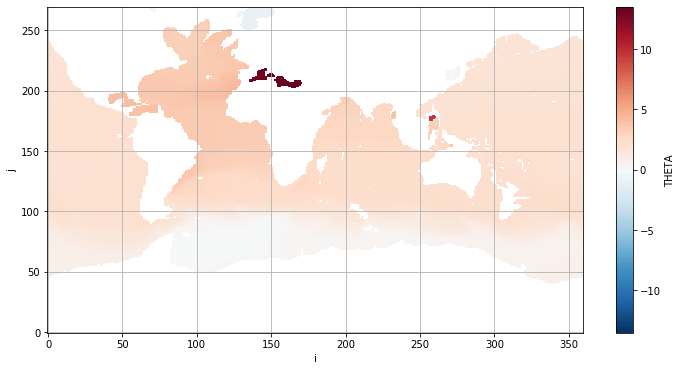

In [12]:
sst_mean_lower.where(surface_mask_lower).plot(figsize=(12,6))
plt.grid();

In [13]:
sst_mean_wg_lower = sst_mean_lower.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg_lower = surface_mask_lower.sel(i=slice(75, 167), j=slice(35, 75))

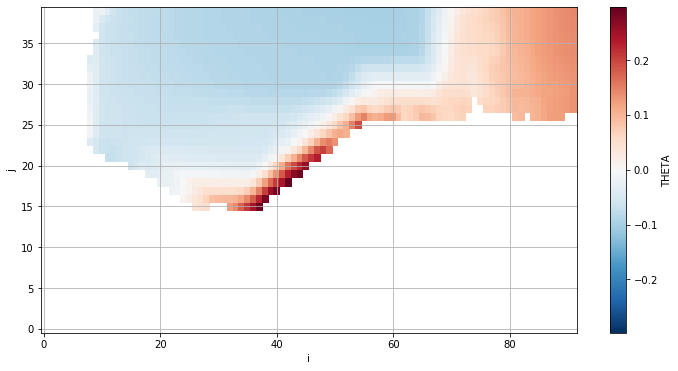

In [14]:
sst_mean_wg_lower.where(surface_mask_wg_lower).plot(figsize=(12,6))
plt.grid();

In [15]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

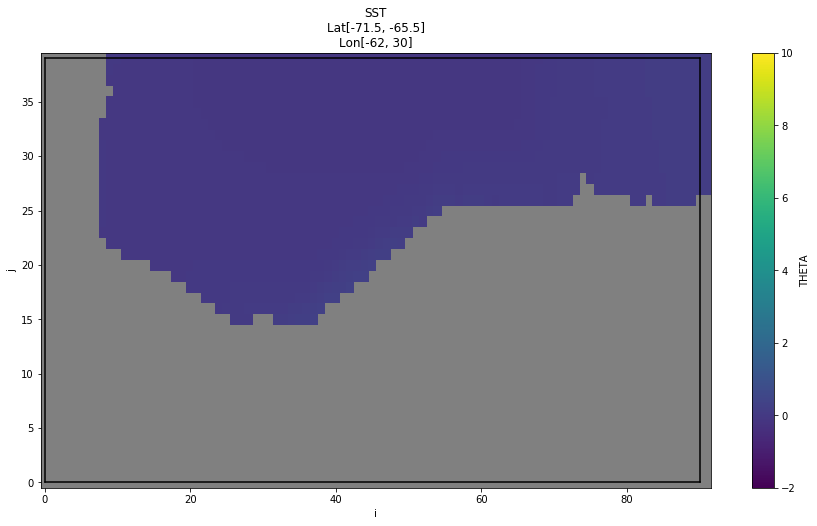

In [16]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sst_mean_wg_lower.where(surface_mask_wg_lower).plot(ax=ax,  vmin=-2, vmax=10)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [17]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167


lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [18]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [63]:
#advective flux
adv_flux_y_lower = ds.ADVy_TH.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
adv_flux_x_lower = ds.ADVx_TH.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
adv_flux_z_lower = ds.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([ -522148.88, -1378639.2 ,  -773351.5 , ..., -2340577.8 ,  -632875.44,
        -973776.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

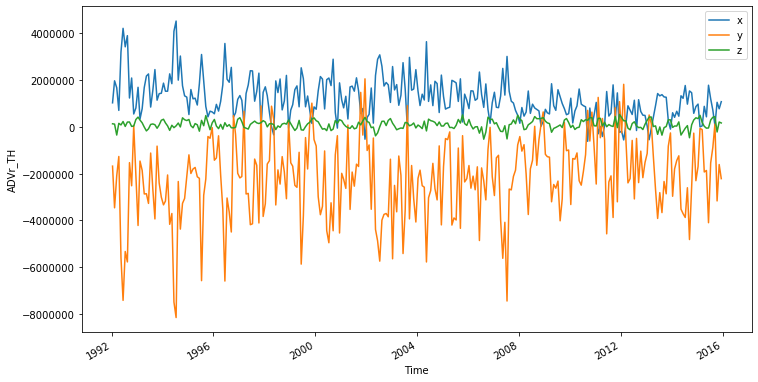

In [64]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [65]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_TH.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
diff_flux_x_lower = ds.DFxE_TH.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
diff_flux_z_lower = ((ds.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])
                    + ds.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([243964.03, 217606.33, 202374.28, ..., 233633.34, 195115.02, 160360.06],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

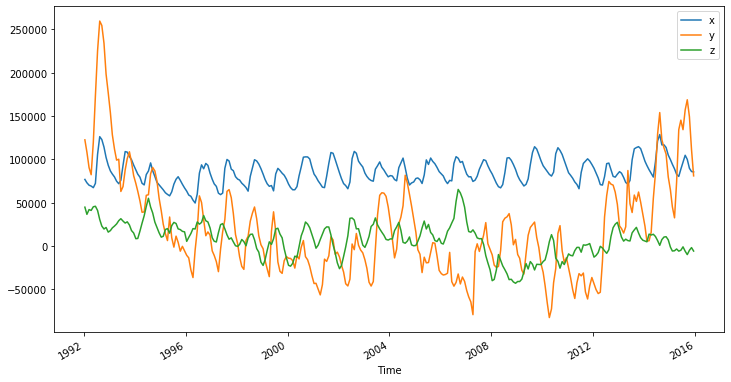

In [66]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [19]:
ds.THETA_snp

<xarray.DataArray 'THETA_snp' (time_snp: 287, k: 50, j: 270, i: 360)>
dask.array<shape=(287, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Dimensions without coordinates: k, j, i
Attributes:
    long_name:      Potential Temperature
    standard_name:  THETA
    units:          degC

In [20]:
theta_scaled = (ds.THETA_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')
theta_scaled

<xarray.DataArray (time_snp: 286, k: 50, j: 270, i: 360)>
dask.array<shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Dimensions without coordinates: k, j, i

In [23]:
ds.dt[1:287]

<xarray.DataArray 'dt' (time: 286)>
array([2505600., 2678400., 2592000., ..., 2592000., 2678400., 2592000.])
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    dt       (time) float64 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06
Attributes:
    units:          s
    standard_name:  dt
    coordinate:     time
    long_name:      time span between snapshots

In [60]:
theta_scaled = xr.DataArray(theta_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': ds.dt[1:287].time.data
#                                     , 'k': theta_scaled['theta_scaled.k.dims'].data, 
#                                                      'j': theta_scaled['theta_scaled.j.dims'].data, 
#                                                      'i': theta_scaled['theta_scaled.i.dims'].data
                                   })
theta_scaled

<xarray.DataArray 'sub-241f31f532fbebafce36f64d616398ca' (time: 286, k: 50, j: 270, i: 360)>
dask.array<shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [61]:
theta_tend = (theta_scaled / ds.dt[1:287])

In [62]:
tottend_weddell_lower = ((theta_tend * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['i', 'j','k']))/ (24*60*60)
tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 286)>
array([13.96179 ,  7.132407,  3.079598, ..., -9.624107, 24.909826,  5.590556])
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    dt       (time) float64 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06

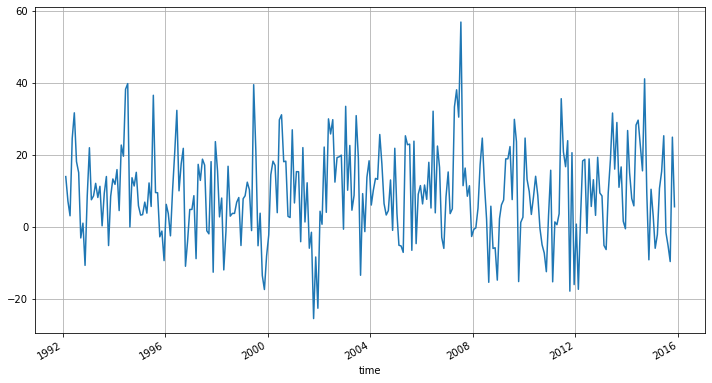

In [69]:
tottend_weddell_lower.plot(figsize=(12,6))
plt.grid()

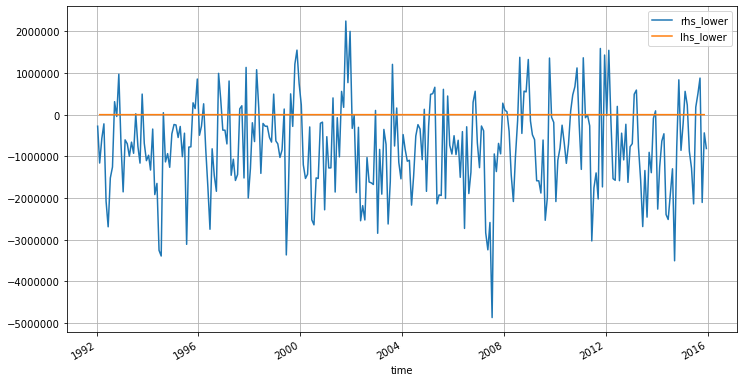

In [67]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower + diff_flux_lower
lhs_lower = - tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();
#plt.savefig('SOSE-heat-inter-rhs-lhs-timeseries', format='pdf')

In [ ]:
rhs_lower.plot(figsize=(12,6))